# Preparing NYC and SF taxi data

This notebook prepares the NYC and SF taxi trip datasets for the LDA analysis
and does some initial exploration

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import geojson as geo
import datetime


In [2]:
# make columns for day and hour
def make_time_cols(df):
    yr, mo, sday, shour, eday, ehour= [],[], [], [], [], []
    for index, row in df.iterrows():
        yr.append(row['startdate'].year)
        mo.append(row['startdate'].month)
        sday.append(row['startdate'].weekday())
        shour.append(row['startdate'].hour)
        eday.append(row['enddate'].weekday())
        ehour.append(row['enddate'].hour)
    df['year'] = yr
    df['month'] = mo
    df['startday'] = sday
    df['starthour'] = shour
    df['endday'] = eday
    df['endhour'] = ehour
    return df
   
# drop missing data and outliers
def drop_missing_data(df):
    l = len(df)
    df = df.dropna(axis=0)
    df = df[(df.o_lng != 0) & (df.o_lat != 0) & (df.d_lng != 0) & (df.d_lat !=0)]
    print 'dropped %s rows' % (l-len(df))
    return df

# define bounding box for new york
# 41.345737, -74.584228
# 40.365230, -71.944763
def drop_outliers_nyc(df):
    l = len(df)
    df = df[(df.o_lng >= -74.584228) & (df.o_lat >= 40.365230) & (df.o_lng <= -71.944763) & (df.o_lat <=41.345737)]
    df = df[(df.d_lng >= -74.584228) & (df.d_lat >= 40.365230) & (df.d_lng <= -71.944763) & (df.d_lat <=41.345737)]
    print 'dropped %s rows' % (l-len(df))
    return df

## define bbox for SF:
# 38.281557, -122.817603
# 36.976475, -121.532203
def drop_outliers_sf(df):
    l = len(df)
    df = df[(df.o_lng >= -122.817603) & (df.o_lat >= 36.976475) & (df.o_lng <= -121.532203) & (df.o_lat <=38.281557)]
    df = df[(df.d_lng >= -122.817603) & (df.d_lat >= 36.976475) & (df.d_lng <= -121.532203) & (df.d_lat <=38.281557)]
    print 'dropped %s rows' % (l-len(df))
    return df


def create_geojson_origins(df):
    feature_list = []
    for i, row in df.iterrows():
        trip_feature = geo.Feature(geometry={'type':'Point', 'coordinates':[row['o_lng'],row['o_lat']]}, id=i, properties={'tripid':i,'dist':row['dist'],'year':row['year'],'month':row['month'],'startday':row['startday'], 'starthour':row['starthour']})
        feature_list.append(trip_feature)
    trip_collection = geo.FeatureCollection(feature_list)
    return trip_collection

def create_geojson_destinations(df):
    feature_list = []
    for i, row in df.iterrows():
        trip_feature = geo.Feature(geometry={'type':'Point', 'coordinates':[row['d_lng'],row['d_lat']]}, id=i, properties={'tripid':i,'dist':row['dist'],'year':row['year'],'month':row['month'],'endday':row['endday'], 'endhour':row['endhour']})
        feature_list.append(trip_feature)
    trip_collection = geo.FeatureCollection(feature_list)
    return trip_collection


## Load and clean data

### SF Data
These come in three separate tables

In [3]:
# load data for October 2013 SF
cols_to_keep = ['STARTDATE','ENDDATE','DIST_SERVCE','GPS_START_LO', 'GPS_START_LA','GPS_END_LO','GPS_END_LA','trip_time']
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
sf_data = pd.read_csv('data/taxi_sf/2013_Oct.csv', usecols= cols_to_keep, parse_dates=['STARTDATE','ENDDATE'], date_parser=dateparse)
sf_data.columns = ['startdate', 'enddate','dist','o_lng','o_lat','d_lng','d_lat','trip_time']
sf_data = drop_missing_data(sf_data)
sf_data = drop_outliers_sf(sf_data)
sf_data = make_time_cols(sf_data)
print sf_data.head()

dropped 482 rows
dropped 21 rows
            startdate             enddate  dist       o_lng      o_lat  \
0 2013-10-01 00:03:00 2013-10-01 00:04:00   5.0 -122.472388  37.804945   
1 2013-10-01 00:05:00 2013-10-01 00:09:00   0.8 -122.400507  37.792920   
2 2013-10-01 00:00:00 2013-10-01 00:09:00   7.5 -122.391168  37.616057   
3 2013-10-01 00:01:00 2013-10-01 00:05:00   1.3 -122.400962  37.787003   
4 2013-10-01 00:05:00 2013-10-01 00:10:00   1.9 -122.466452  37.765732   

        d_lng      d_lat  trip_time  year  month  startday  starthour  endday  \
0 -122.472953  37.805305         60  2013     10         1          0       1   
1 -122.414613  37.791295        240  2013     10         1          0       1   
2 -122.324047  37.555052        540  2013     10         1          0       1   
3 -122.414220  37.781912        240  2013     10         1          0       1   
4 -122.465177  37.742243        300  2013     10         1          0       1   

   endhour  
0        0  
1        

In [36]:
# for SF July-Sep 2013  (these tables have different columns)

cols_to_keep = ['startdate','enddate','dist_servce','gps_start_lo', 'gps_start_la','gps_end_lo','gps_end_la','trip_time']
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
sf_data2 = pd.read_csv('data/taxi_sf/2013_July_Aug_Sep.csv', usecols= cols_to_keep, parse_dates=['startdate','enddate'], date_parser=dateparse)
sf_data2.columns = ['startdate', 'enddate','dist','o_lng','o_lat','d_lng','d_lat','trip_time']
sf_data2 = drop_missing_data(sf_data2)
sf_data2 = drop_outliers_sf(sf_data2)
sf_data2 = make_time_cols(sf_data2)
print sf_data2.head()

dropped 1064 rows
dropped 63 rows
            startdate             enddate  dist     o_lng     o_lat     d_lng  \
0 2013-07-01 00:25:00 2013-07-01 00:35:00   2.6 -122.4272  37.76879 -122.3888   
1 2013-07-01 01:21:00 2013-07-01 01:25:00   0.8 -122.4113  37.78609 -122.4102   
2 2013-07-01 01:43:00 2013-07-01 01:52:00   2.5 -122.4354  37.76087 -122.4045   
3 2013-07-01 02:32:00 2013-07-01 02:45:00   3.3 -122.4349  37.76077 -122.4184   
4 2013-07-01 03:03:00 2013-07-01 03:07:00   1.2 -122.4026  37.77839 -122.4198   

      d_lat  trip_time  year  month  startday  starthour  endday  endhour  
0  37.76186        600  2013      7         0          0       0        0  
1  37.79648        240  2013      7         0          1       0        1  
2  37.77759        540  2013      7         0          1       0        1  
3  37.79830        780  2013      7         0          2       0        2  
4  37.78300        240  2013      7         0          3       0        3  


In [37]:
# load oct 2012 SF data

cols_to_keep = ['STARTDATE','ENDDATE','DIST_BS','GPS_START_LO', 'GPS_START_LA','GPS_END_LO','GPS_END_LA']
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
sf_data3 = pd.read_csv('taxi_sf/2012_Oct.csv', usecols= cols_to_keep, parse_dates=['STARTDATE','ENDDATE'], date_parser=dateparse)
sf_data3.columns = ['startdate', 'enddate','dist','o_lng','o_lat','d_lng','d_lat']
sf_data3 = drop_missing_data(sf_data3)     
sf_data3 = drop_outliers_sf(sf_data3)
sf_data3 = make_time_cols(sf_data3)
print sf_data3.head()

dropped 239 rows
dropped 25 rows
            startdate             enddate  dist       o_lng      o_lat  \
0 2012-10-01 00:14:00 2012-10-01 00:23:00     0 -122.429297  37.767068   
1 2012-10-01 00:19:00 2012-10-01 00:27:00     0 -122.396335  37.793892   
2 2012-10-01 00:30:00 2012-10-01 00:40:00     0 -122.441028  37.776520   
3 2012-10-01 03:51:00 2012-10-01 03:58:00     0 -122.452608  37.786517   
4 2012-10-01 04:16:00 2012-10-01 04:16:00     0 -122.396175  37.744573   

        d_lng      d_lat  year  month  startday  starthour  endday  endhour  
0 -122.410560  37.787002  2012     10         0          0       0        0  
1 -122.430847  37.790810  2012     10         0          0       0        0  
2 -122.397030  37.778637  2012     10         0          0       0        0  
3 -122.404288  37.792333  2012     10         0          3       0        3  
4 -122.396173  37.744577  2012     10         0          4       0        4  


In [51]:
# put all together in one dataframe
sf_data_all = pd.concat([sf_data, sf_data2, sf_data3], ignore_index=True)
len(sf_data_all)

702032

In [52]:
len(sf_data_all.index.unique())

702032

In [53]:
# save as geojson for spatial join with TAZ geometry. 
sf_o_geo = create_geojson_origins(sf_data_all)
sf_d_geo = create_geojson_destinations(sf_data_all)

# write to json file
with open('working_data/sf_trips_o.json', 'w') as fp:
    json.dump(sf_o_geo, fp)
with open('working_data/sf_trips_d.json', 'w') as fp:
    json.dump(sf_d_geo, fp)

In [18]:
sf_o_geo2 = create_geojson_origins(sf_data2)
sf_d_geo2 = create_geojson_destinations(sf_data2)

In [19]:
# write to json file
with open('working_data/sf_trips_o_jul13.json', 'w') as fp:
    json.dump(sf_o_geo2, fp)
with open('working_data/sf_trips_d_jul13.json', 'w') as fp:
    json.dump(sf_d_geo2, fp)

In [11]:
sf_o_geo = create_geojson_origins(sf_data)
sf_d_geo = create_geojson_destinations(sf_data)

# write to json file
with open('working_data/sf_trips_o_oct12.json', 'w') as fp:
    json.dump(sf_o_geo, fp)
with open('working_data/sf_trips_d_oct12.json', 'w') as fp:
    json.dump(sf_d_geo, fp)

In [65]:
# also store dataframe for trip ID reference
sf_data_all.to_hdf('working_data/taxi_sf/sf_data_all.h5','df')

In [12]:
#sf_data2 = pd.read_csv('taxi_sf/2012_Oct.csv')
#sf_data2.columns

Index([u'ReadDate', u'TYPEID', u'STARTDATE', u'ENDDATE', u'Fares_Worked', u'Trips', u'Extras', u'Taxes', u'Tips', u'Total_amount', u'DIST_BS', u'DIST_SERVCE', u'Total_Tolls', u'DRIVERID', u'GPS_START_LO', u'GPS_START_LA', u'GPS_END_LO', u'GPS_END_LA', u'PASSENGER_NUM', u'NUM_CREDIT_SERVICES', u'Batch', u'Cabnumber', u'PAYTYPE', u'FROM_ADDRESS', u'TO_ADDRESS', u'DISPATCHID'], dtype='object')

### NYC Data

In [131]:
# load full NYC dataset
cols_to_keep = [' pickup_datetime',' dropoff_datetime',' trip_time_in_secs',' trip_distance',' pickup_longitude',' pickup_latitude',' dropoff_longitude',' dropoff_latitude']
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
nyc_data = pd.read_csv('data/taxi_nyc/trip_data_10.csv', usecols = cols_to_keep, parse_dates=[' pickup_datetime',' dropoff_datetime'])
nyc_data.columns = ['startdate','enddate','trip_time','dist','o_lng','o_lat','d_lng','d_lat']

# We don't need such a large dataset, especially since the SF set is so much smaller. 
#So randomly sample 10% of rows 
rows = np.random.choice(nyc_data.index.values, len(nyc_data)*.1, replace = False)
nyc_sample = nyc_data.ix[rows]

#nyc_data = nyc_sample

In [60]:
##  temporarily save, and load
#nyc_sample.to_csv('taxi_nyc/nyc_sample.csv', index = False)

store = pd.HDFStore('working_data/taxi_nyc/nyc_sample.h5')
#store['df'] = nyc_sample
nyc_data = store['df']
nyc_data.head()

,startdate,enddate,trip_time,dist,o_lng,o_lat,d_lng,d_lat
3059374,2013-10-21 07:38:49,2013-10-21 07:56:54,1084,4.60,-73.923874,40.770187,-73.952225,40.772835
1480323,2013-10-14 13:17:10,2013-10-14 13:35:49,1118,11.20,-73.970627,40.754700,-73.865089,40.770554
3914387,2013-10-22 22:49:28,2013-10-22 22:53:29,240,1.10,-74.009956,40.735149,-73.999443,40.743870
13323926,2013-10-30 22:04:00,2013-10-30 22:11:00,420,0.75,-73.972542,40.764717,-73.971870,40.757217
11665692,2013-10-24 10:09:00,2013-10-24 10:18:00,540,1.38,-73.962212,40.755596,-73.949509,40.772549


In [61]:
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#nyc_data = pd.read_csv('taxi_nyc/nyc_sample.csv', parse_dates=['startdate','enddate'], date_parser=dateparse)
nyc_data = pd.read_hdf('working_data/taxi_nyc/nyc_sample.h5')
nyc_data = drop_missing_data(nyc_data)
nyc_data = drop_outliers_nyc(nyc_data)
nyc_data = make_time_cols(nyc_data)
nyc_data.head()

dropped 18589 rows
dropped 110 rows


,startdate,enddate,trip_time,dist,o_lng,o_lat,d_lng,d_lat,year,month,startday,starthour,endday,endhour
3059374,2013-10-21 07:38:49,2013-10-21 07:56:54,1084,4.60,-73.923874,40.770187,-73.952225,40.772835,2013,10,0,7,0,7
1480323,2013-10-14 13:17:10,2013-10-14 13:35:49,1118,11.20,-73.970627,40.754700,-73.865089,40.770554,2013,10,0,13,0,13
3914387,2013-10-22 22:49:28,2013-10-22 22:53:29,240,1.10,-74.009956,40.735149,-73.999443,40.743870,2013,10,1,22,1,22
13323926,2013-10-30 22:04:00,2013-10-30 22:11:00,420,0.75,-73.972542,40.764717,-73.971870,40.757217,2013,10,2,22,2,22
11665692,2013-10-24 10:09:00,2013-10-24 10:18:00,540,1.38,-73.962212,40.755596,-73.949509,40.772549,2013,10,3,10,3,10


In [10]:
nyc_o_geo = create_geojson_origins(nyc_data)
nyc_d_geo = create_geojson_destinations(nyc_data)

# write to json file
with open('working_data/nyc_trips_o.json', 'w') as fp:
    json.dump(nyc_o_geo, fp)
with open('working_data/nyc_trips_d.json', 'w') as fp:
    json.dump(nyc_d_geo, fp)

In [67]:
# save this to in case we need it. 
nyc_data.to_hdf('working_data/taxi_nyc/nyc_data.h5','df')

In [68]:
store.close()

# Explore data

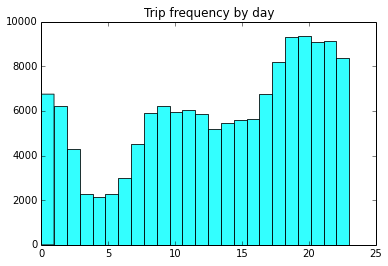

In [147]:
# plot by day of week and time of day
def hist_time(x):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    numBins = 24
    ax.hist(x,numBins,color='cyan',alpha=0.8)
    ax.set_title('Trip frequency by day')
    plt.show()
    
hist_time(sf_data2.starthour)
#hist_time(nyc_data.starthour)
#hist_time(bos_data.starthour)

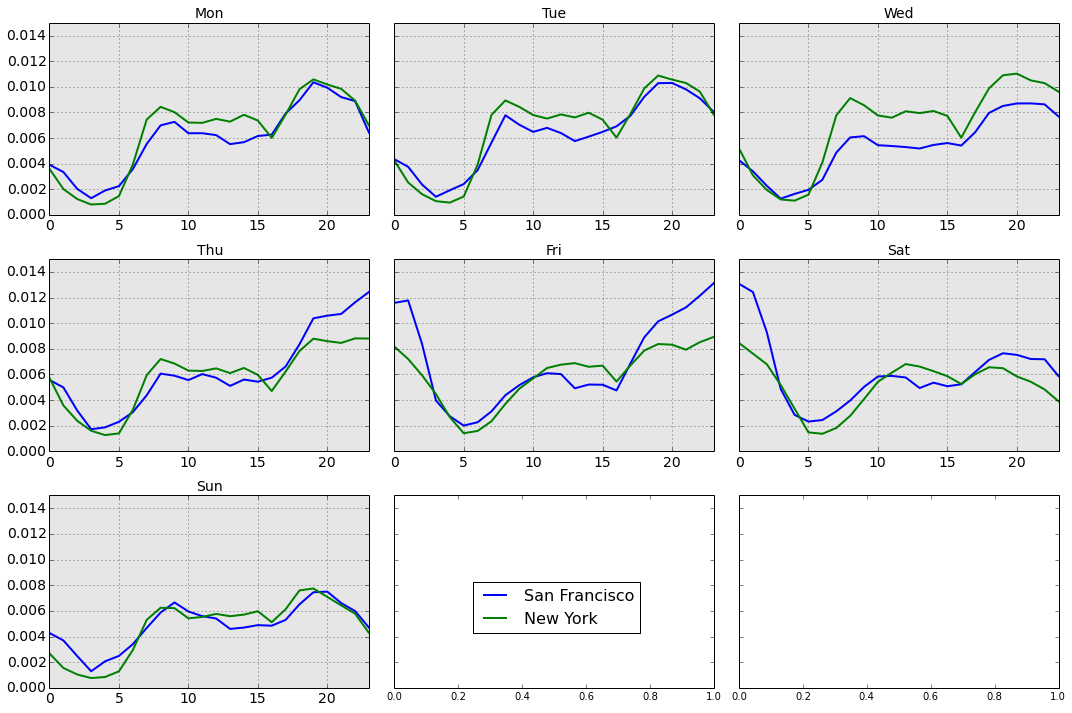

In [139]:
import matplotlib.lines as mlines

# plots a comparison of trips by hour for days of the week
# df_list is a list of cities' data
# day_list is a list of weekdays to plot
def compare_trips_by_hour(df_list):
    day_list = [1,2,3,4,5,6,0]
    labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    
    # create subplots
    
    fig, axs = plt.subplots(3,3, sharex = False, sharey = True)
    fig.set_size_inches(15,10)
    
    
    for i, a in enumerate(axs.flat):
        if i <= 6:
            
            for j, df in enumerate(df_list):
                mask = df.startday == day_list[i]
                grouped = df[mask].groupby(['starthour']).count()
                x = grouped.index
                y = grouped.startdate/(len(df)*1.0)
                a.plot(x,y, linewidth=2.0)
            
            #mask = df_list[0].startday == day_list[i]
            #grouped = df_list[0][mask].groupby(['starthour']).count()
            #x1 = grouped.index
            #y1 = grouped.startdate/(len(df_list[0])*1.0)
            #l1 = a.plot(x1,y1)
            
            a.set_ylim([0,0.015])
            a.set_xlim([0,23])
            a.grid(True)
            a.set_axis_bgcolor('.9')
            a.tick_params(axis='both', which='major', labelsize=14)
            #a.set_aspect(1.5)
            #a.set_xticklabels([])
            #a.set_yticklabels([])

            a.set_title(labels[i], fontsize = 14)
    
    #plt.tick_params(axis='both', which='minor', labelsize=8)
    line1 = mlines.Line2D([], [], color='blue', linewidth = 2.0)
    line2 = mlines.Line2D([], [], color='green', linewidth = 2.0)
    fig.legend([line1, line2], ['San Francisco','New York'], bbox_to_anchor=(.6,.1), loc = 'lower right', prop={'size':16})
    plt.tight_layout()
    plt.show()

compare_trips_by_hour([sf_data2, nyc_data])


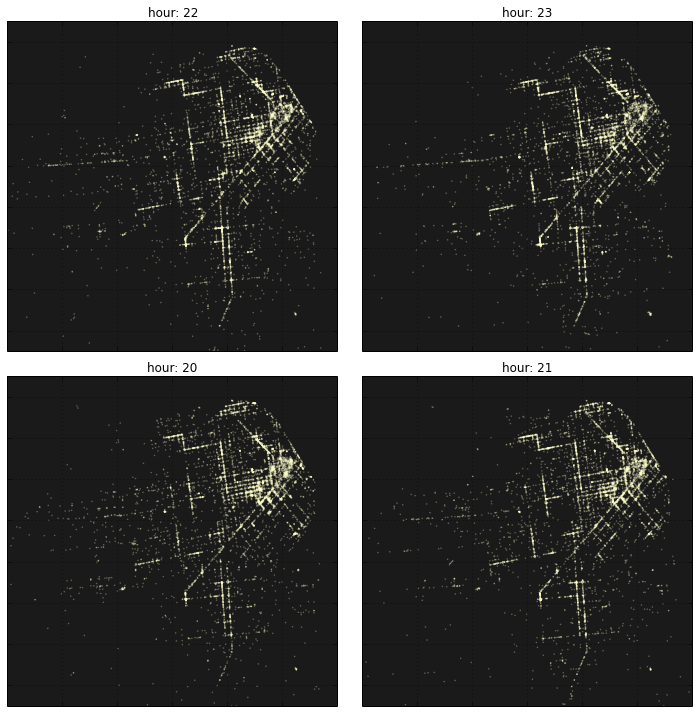

In [8]:
# simple map of trip origins or destinations at different times of day. 
# define bounding box for each city
bbox = {'sf':[[-122.5,-122.38],[37.735,37.815]], 'bos':[[-71.16, -71.01],[42.32,42.38]], 'nyc':[[-74.05, -73.9,],[40.67, 40.80]]}

## plots coordinate locations of pickups at four different hour intervals
# hlist is a list of four integers indicating hour intervals
def plot_locations_by_hour(df, hlist):
    fig, axs = plt.subplots(2,2)
    fig.set_size_inches(10,10)
    
    xlim = bbox['sf'][0]
    ylim = bbox['sf'][1]
    
    for i, a in enumerate(axs.flat):
        x = df[df.starthour == hlist[i]].o_lng
        y = df[df.starthour == hlist[i]].o_lat
        a.scatter(x,y,color='#ffffcc',s=.3, alpha = .3)
        a.set_ylim(ylim)
        a.set_xlim(xlim)
        a.grid(True)
        a.set_aspect(1.5)
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_axis_bgcolor('.1')
        
        title = 'hour: %s' %hlist[i]
        a.set_title(title)
    plt.tight_layout()
    plt.show()

plot_locations_by_hour(sf_data, [22, 23, 20, 21])


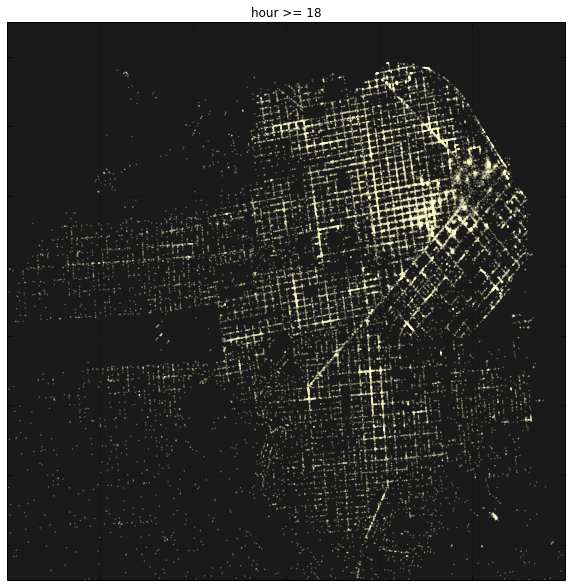

In [23]:
# make just one plot 

## plots coordinate locations of pickups at four different hour intervals
# hlist is a list of four integers indicating hour intervals
def plot_locations_by_hour(df):
    fig, axs = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    
    xlim = bbox['sf'][0]
    ylim = bbox['sf'][1]
    
    
    x = df[df.starthour >= 18].d_lng
    y = df[df.starthour >= 18].d_lat
    axs.scatter(x,y,color='#ffffcc',s=.3, alpha = .3)
    axs.set_ylim(ylim)
    axs.set_xlim(xlim)
    axs.grid(True)
    axs.set_aspect(1.5)
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    axs.set_axis_bgcolor('.1')

    title = 'hour >= %s' %18 
    axs.set_title(title)
    #plt.tight_layout()
    plt.show()

plot_locations_by_hour(sf_data)

In [7]:
# I also tried using data from Boston but it was just a sample of trips in the city center - not useful. 

dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%y %I:%M %p')

cols_to_keep = ['TRIP_ID','PICKUPTIME','PICKUPLONG','PICKUPLAT']
bos_pickups = pd.read_csv('data/Taxi_Boston/filtered_taxi_10_12/filtered_pickups_10_12.csv', usecols=cols_to_keep, dtype = {'TRIP_ID': str}, parse_dates=['PICKUPTIME'], date_parser=dateparse)
bos_pickups.columns = ['trip_id','startdate','o_lng','o_lat']

cols_to_keep = ['TRIP_ID','DROPTIME','DROPLONG','DROPLAT']
bos_dropoffs = pd.read_csv('data/Taxi_Boston/filtered_taxi_10_12/filtered_dropoffs_10_12.csv', usecols= cols_to_keep, dtype = {'TRIP_ID': str}, parse_dates=['DROPTIME'], date_parser=dateparse)
bos_dropoffs.columns = ['trip_id','enddate','d_lng','d_lat']

bos_data = pd.merge(bos_pickups, bos_dropoffs, on= 'trip_id')

bos_data = drop_missing_data(bos_data)
bos_data = make_time_cols(bos_data)

print bos_data.head()

dropped 0 rows
  trip_id           startdate      o_lng      o_lat             enddate  \
0       1 2012-10-01 00:02:00 -71.076678  42.348068 2012-10-01 00:04:00   
1       4 2012-10-01 00:05:00 -71.018740  42.369023 2012-10-01 00:13:00   
2       6 2012-10-01 00:10:00 -71.017226  42.366326 2012-10-01 00:19:00   
3       7 2012-10-01 00:11:00 -71.071165  42.344273 2012-10-01 00:13:00   
4      10 2012-10-01 00:15:00 -71.018990  42.369455 2012-10-01 00:21:00   

       d_lng      d_lat  startday  starthour  endday  endhour  
0 -71.076500  42.341455         0          0       0        0  
1 -71.063682  42.354295         0          0       0        0  
2 -71.053179  42.357489         0          0       0        0  
3 -71.077715  42.348672         0          0       0        0  
4 -71.054290  42.367867         0          0       0        0  
